In [1]:
import json
from typing import Dict, Any, List, Optional
import requests
from bs4 import BeautifulSoup

''' 
# LLM & embeddings
from langchain.chat_models import ChatOpenAI  # optional, can also use other providers
from langchain import LLMChain, PromptTemplate
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix

'''
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
import matplotlib.pyplot as plt


In [2]:
LLM_API_CONFIG: Dict[str, Any] = {
    "endpoint": "http://localhost:11434/api/generate", 
    "model": "llama3.2:3b",
    "temperature": 0.4,
    "stream": False,
    "timeout_seconds": 500,
}

INTERPRETER_SOURCES = "https://www.diezminutos.es/horoscopo/g33975789/horoscopo-semanal/"

In [3]:
SUMMARIZER_PROMPT = """You are an expert astrologer assistant.
Summarize the given horoscope text in structured JSON with these fields:
{
  "tone": "string - general emotional tone (e.g., hopeful, reflective, energetic)",
  "facets": {
    "love": "string - what it says about love",
    "career": "string - what it says about work or goals",
    "health": "string - what it says about physical/emotional health"
  },
  "key_points": ["string - main ideas or advice points"],
  "final_summary": "string - overall message of the horoscope"
}
Return ONLY JSON.
"""

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()],
)

In [4]:
SIGNS = [
    "Aries","Tauro","Géminis","Cáncer","Leo","Virgo",
    "Libra","Escorpio","Sagitario","Capricornio","Acuario","Piscis"
]

DATE = "31 october 2025"

sign_summaries = {}


## Scraping

In [5]:
def scrape(sign: str, date: str = "this_week", interpreter: str = "DiezMinutos") -> str:
    """
    Extract horoscope text for a specific zodiac sign from DiezMinutos' JSON-LD.
    """
    url = "https://www.diezminutos.es/horoscopo/g33975789/horoscopo-semanal/"
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118 Safari/537.36"
    }

    logging.info(f"Scraping {sign} from DiezMinutos horóscopo...")

    resp = requests.get(url, headers=headers, timeout=10)
    if resp.status_code != 200:
        return f"(fallback) Could not fetch horoscope page (status {resp.status_code})"

    soup = BeautifulSoup(resp.text, "html.parser")

    # Find the JSON-LD script with all horoscope data
    script_tag = soup.find("script", {"id": "json-ld", "type": "application/ld+json"})
    if not script_tag:
        return f"(fallback) No JSON-LD found at {url}"

    try:
        data = json.loads(script_tag.string)
    except Exception as e:
        return f"(fallback) Could not parse JSON-LD: {e}"

    # Locate the "ItemList" with all horoscope items
    item_list = None
    for block in data:
        if isinstance(block, dict) and block.get("@type") == "ItemList":
            item_list = block.get("itemListElement")
            break

    if not item_list:
        return f"(fallback) No horoscope items found in JSON-LD for {url}"

    # Normalize sign and find its entry
    target_sign = sign.strip().lower()
    for item in item_list:
        name = item.get("name", "").lower()
        if target_sign in name:
            return item.get("description", "(no description found)")

    return f"(fallback) No horoscope found for sign '{sign}'"


In [6]:
text = scrape("Tauro")
print(text[:400])

2025-11-03 23:26:00,690 - INFO - Scraping Tauro from DiezMinutos horóscopo...


Salud: Intenta comer más despacio para mejorar las digestiones. No te excedas si sales de fiesta, luego te cuesta recuperarte. Tu estado de ánimo será bueno gracias a la influencia de Mercurio en tu signo.Amor: Te vas a dar cuenta de que tu pareja te quiere más de lo que creías y en tu hogar las peleas ya no van a estar a la orden del día. Todo esto hará que el romanticismo al final de cada jornad


## Summarizing

In [7]:
def summarize(raw_text: str) -> Optional[Dict[str, Any]]:
    logging.info("Summarizing horoscope via LLM...")

    try:
        response = requests.post(
            LLM_API_CONFIG["endpoint"],
            json={
                "model": LLM_API_CONFIG["model"],
                "prompt": f"{SUMMARIZER_PROMPT}\n\n{raw_text}",
                "stream": LLM_API_CONFIG["stream"],
                "options": {
                    "temperature": LLM_API_CONFIG["temperature"],
                },
            },
            timeout=LLM_API_CONFIG["timeout_seconds"],
        )
        response.raise_for_status()

        raw_output = response.json()["response"].strip()

        if "```" in raw_output:
            raw_output = raw_output.split("```")[1]
        if "{" in raw_output:
            raw_output = raw_output[raw_output.find("{"):]
        if raw_output.endswith("```"):
            raw_output = raw_output[:-3]


        return json.loads(raw_output)
    
    except json.JSONDecodeError as e:
        logging.error(f"⚠️ JSON parse failed: {e}")
        logging.error(f"Model raw output:\n{raw_output[:500]}...")
        return {"error": "invalid_json", "raw_output": raw_output[:300]}
    
    except Exception as e:
        logging.error(f"Summarization failed: {str(e)}")
        return None

In [8]:
def run_agent(sign: str, date: str = "today", interpreter: str = "DiezMinutos") -> Dict[str, Any]:
    log = []
    try:
        # Step 1: Thought → Scrape
        log.append({"thought": f"I need to get the horoscope for {sign} from {interpreter}."})
        raw_text = scrape(sign, date, interpreter)
        log.append({"action": f"scrape({sign}, {date}, {interpreter})"})
        log.append({"observation": f"Retrieved {len(raw_text)} characters of text."})

        # Step 2: Thought → Summarize
        log.append({"thought": "Now I need to summarize the text into structured JSON."})
        summary = summarize(raw_text)
        log.append({"action": "summarize(raw_text)"})
        log.append({"observation": f"Summary created with keys: {list(summary.keys()) if summary else 'None'}"})

        # Step 3: Final answer
        final_answer = {
            "sign": sign,
            "interpreter": interpreter,
            "date": date,
            "raw_text_sample": raw_text[:200] + "...",
            "summary": summary or {"error": "Summarization failed"},
        }
        log.append({"final_answer": final_answer})

        # Save log
        with open(f"react_log_{sign.lower()}.json", "w", encoding="utf-8") as f:
            json.dump(log, f, indent=2, ensure_ascii=False)

        return final_answer

    except Exception as e:
        logging.error(f"Agent failed: {e}")
        return {"error": str(e)}

## Running algorithm

In [9]:
for sign in SIGNS:
    print(f"Processing {sign}...")
    result = run_agent(sign)

    # Defensive handling: summary might be missing or incomplete
    summary = result.get("summary", {})
    tone = summary.get("tone", "Unknown")
    final_summary = summary.get("final_summary", "No summary available.")
    facets = summary.get("facets", {
        "love": "No data",
        "career": "No data",
        "health": "No data"
    })
    key_points = summary.get("key_points", [])
    final_summary = summary.get("final_summary", "No summary available.")

    # Store final_summary only
    sign_summaries[sign] = {
        "tone": tone,
        "facets": facets,
        "key_points": key_points,
        "final_summary": final_summary
    }

# Save everything to one JSON for the embeddings step

with open("horoscope_summaries.json", "w", encoding="utf-8") as f:
    json.dump(sign_summaries, f, indent=2, ensure_ascii=False)

print("Saved all summaries to all_signs_summaries.json")

2025-11-03 23:26:00,945 - INFO - Scraping Aries from DiezMinutos horóscopo...
2025-11-03 23:26:01,048 - INFO - Summarizing horoscope via LLM...


Processing Aries...


2025-11-03 23:26:11,560 - INFO - Scraping Tauro from DiezMinutos horóscopo...
2025-11-03 23:26:11,695 - INFO - Summarizing horoscope via LLM...


Processing Tauro...


2025-11-03 23:26:15,583 - INFO - Scraping Géminis from DiezMinutos horóscopo...
2025-11-03 23:26:15,781 - INFO - Summarizing horoscope via LLM...


Processing Géminis...


2025-11-03 23:26:19,639 - INFO - Scraping Cáncer from DiezMinutos horóscopo...
2025-11-03 23:26:19,751 - INFO - Summarizing horoscope via LLM...


Processing Cáncer...


2025-11-03 23:26:25,160 - INFO - Scraping Leo from DiezMinutos horóscopo...


Processing Leo...


2025-11-03 23:26:25,408 - INFO - Summarizing horoscope via LLM...
2025-11-03 23:26:30,671 - INFO - Scraping Virgo from DiezMinutos horóscopo...
2025-11-03 23:26:30,805 - INFO - Summarizing horoscope via LLM...


Processing Virgo...


2025-11-03 23:26:36,723 - INFO - Scraping Libra from DiezMinutos horóscopo...


Processing Libra...


2025-11-03 23:26:37,830 - INFO - Summarizing horoscope via LLM...
2025-11-03 23:26:42,853 - INFO - Scraping Escorpio from DiezMinutos horóscopo...
2025-11-03 23:26:43,018 - INFO - Summarizing horoscope via LLM...


Processing Escorpio...


2025-11-03 23:26:48,336 - INFO - Scraping Sagitario from DiezMinutos horóscopo...
2025-11-03 23:26:48,460 - INFO - Summarizing horoscope via LLM...


Processing Sagitario...


2025-11-03 23:26:53,361 - INFO - Scraping Capricornio from DiezMinutos horóscopo...
2025-11-03 23:26:53,506 - INFO - Summarizing horoscope via LLM...


Processing Capricornio...


2025-11-03 23:26:58,473 - INFO - Scraping Acuario from DiezMinutos horóscopo...
2025-11-03 23:26:58,603 - INFO - Summarizing horoscope via LLM...


Processing Acuario...


2025-11-03 23:27:02,819 - INFO - Scraping Piscis from DiezMinutos horóscopo...
2025-11-03 23:27:02,938 - INFO - Summarizing horoscope via LLM...


Processing Piscis...
Saved all summaries to all_signs_summaries.json


## Embeddings

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


/Users/nicole/opt/anaconda3/envs/embeddings_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch, numpy as np
print("Torch:", torch.__version__)
print("Numpy:", numpy.__version__)
print(torch.randn(2,2).numpy())




Torch: 2.2.2
Numpy: 1.26.4
[[ 1.2259337   0.35077894]
 [ 0.7142062  -0.84105325]]


In [10]:
import json

with open("horoscope_summaries.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    
texts = []
labels = []
for sign, info in data.items():
    combined_text = (
        f"Tone: {info.get('tone', '')}. "
        f"Love: {info.get('facets', {}).get('love', '')}. "
        f"Career: {info.get('facets', {}).get('career', '')}. "
        f"Health: {info.get('facets', {}).get('health', '')}. "
        f"Key points: {'; '.join(info.get('key_points', []))}. "
        f"Summary: {info.get('final_summary', '')}"
    )
    texts.append(combined_text)
    labels.append(sign)

print(f" Loaded {len(texts)} horoscope summaries.")

model_bge = SentenceTransformer("BAAI/bge-large-en-v1.5")
embeddings = model_bge.encode(texts, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)

model_minilm = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_2 = model_minilm.encode(texts, normalize_embeddings=True)
print("MiniLM embeddings shape:", embeddings_2.shape)


 Loaded 12 horoscope summaries.
Embeddings shape: (12, 1024)
✅ MiniLM embeddings shape: (12, 384)


## PCA

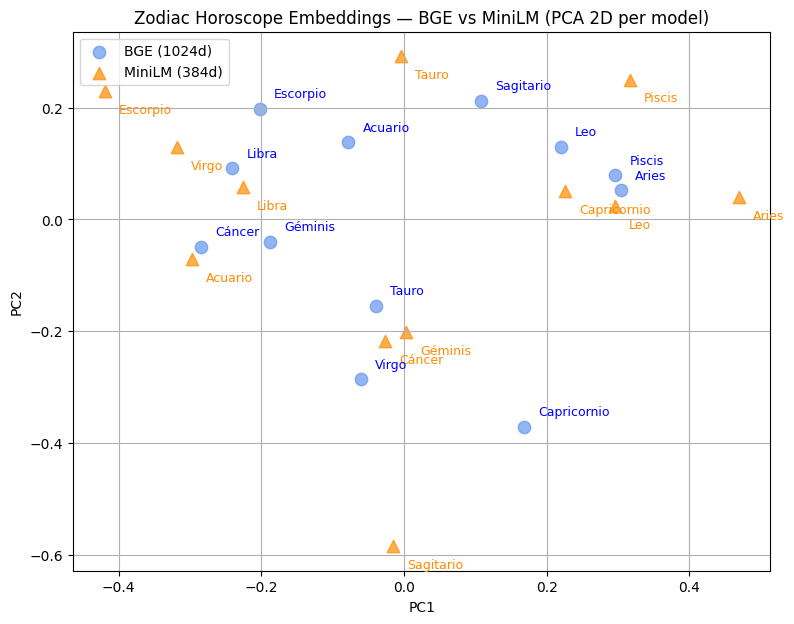

In [13]:
pca_bge = PCA(n_components=2)
reduced_bge = pca_bge.fit_transform(embeddings)

pca_minilm = PCA(n_components=2)
reduced_minilm = pca_minilm.fit_transform(embeddings_2)

# Plot both projections in one figure
plt.figure(figsize=(9, 7))
plt.scatter(reduced_bge[:, 0], reduced_bge[:, 1],
            color="cornflowerblue", label="BGE (1024d)", alpha=0.7, s=80)
plt.scatter(reduced_minilm[:, 0], reduced_minilm[:, 1],
            color="darkorange", label="MiniLM (384d)", alpha=0.7, s=80, marker="^")

for i, label in enumerate(labels):
    plt.text(reduced_bge[i, 0]+0.02, reduced_bge[i, 1]+0.02, label, fontsize=9, color="blue")
    plt.text(reduced_minilm[i, 0]+0.02, reduced_minilm[i, 1]-0.04, label, fontsize=9, color="darkorange")

plt.title("Zodiac Horoscope Embeddings — BGE vs MiniLM (PCA 2D per model)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## PCA + K-MEANS (with k=12)

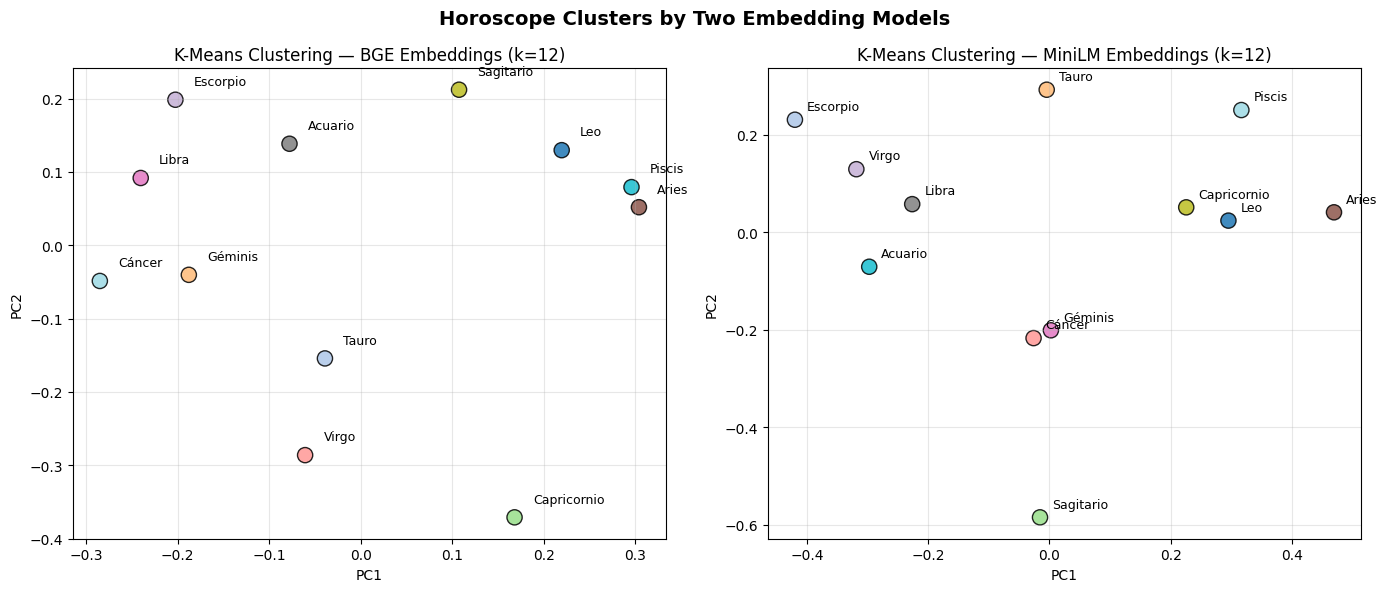

In [15]:
pca1 = PCA(n_components=2)
reduced1 = pca1.fit_transform(embeddings)

pca2 = PCA(n_components=2)
reduced2 = pca2.fit_transform(embeddings_2)

# --- K-Means for both embedding sets ---
kmeans1 = KMeans(n_clusters=12, random_state=42)
clusters1 = kmeans1.fit_predict(embeddings)

kmeans2 = KMeans(n_clusters=12, random_state=42)
clusters2 = kmeans2.fit_predict(embeddings_2)

# --- Plot both side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(reduced1[:, 0], reduced1[:, 1], c=clusters1, cmap="tab20", s=120, alpha=0.85, edgecolors="k")
for i, label in enumerate(labels):
    axes[0].text(reduced1[i, 0] + 0.02, reduced1[i, 1] + 0.02, label, fontsize=9)
axes[0].set_title("K-Means Clustering — BGE Embeddings (k=12)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(reduced2[:, 0], reduced2[:, 1], c=clusters2, cmap="tab20", s=120, alpha=0.85, edgecolors="k")
for i, label in enumerate(labels):
    axes[1].text(reduced2[i, 0] + 0.02, reduced2[i, 1] + 0.02, label, fontsize=9)
axes[1].set_title("K-Means Clustering — MiniLM Embeddings (k=12)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True, alpha=0.3)

plt.suptitle("Horoscope Clusters by Two Embedding Models", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()